In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import optuna


In [2]:
torch.cuda.is_available()

True

In [3]:
# Check if GPU is available and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


1 loading the data from fetch_openml

In [4]:
# loading the data
def load_mnist():
    #MNIST contains 70,000 handwritten digit images (0-9)
    #Each image is 28x28 pixels (flattened to 784 features)
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X, y =mnist.data, mnist.target.astype(np.uint8) # Convert labels to integers
    return X , y

X, y = load_mnist()

2 preprocessing

In [5]:
# Normalize pixel values (0-255) to 0-1 range
X = X / 255.0

train_validation_test

In [6]:
x_train, x_temp, y_train, y_temp = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

3 Simple Classifier with SKLearn. 
Try a simple Random Forest classifier
to establish a baseline accuracy.

In [7]:
# Create a random forest model as baseline
rf_model = RandomForestClassifier(n_estimators=100)
# train model on train set
rf_model.fit(x_train, y_train)
# evaluate model on validation set
y_validation_pred = rf_model.predict(x_val)
rf_accuracy = accuracy_score(y_val,y_validation_pred)

In [8]:
print(f"rf_accuracy:{rf_accuracy:.4}")

rf_accuracy:0.963


so far, by just using a simple and random model of Random Forest, a baseline accuracy is achieved with which the accuracy of NN model can be compared 

4 PyTorch setup

In [9]:
# convert data to tensor
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

In [10]:
# create dataset 
train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
val_dataset = TensorDataset(x_val_tensor,y_val_tensor)
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)

In [11]:
# create DataLoader 
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

preprocess => train test => to tensor => TensorDataset => DataLoader

setup for PyTorch training : model & optimizer & loss   =>  training loop

In [12]:
class MNISTClass(nn.Module):
    def __init__(self, in_size, h_size, o_size):
        super( MNISTClass , self).__init__()

        layers = []

        #input layer
        layers.append(nn.Linear(in_size, h_size[0]))
        layers.append(nn.BatchNorm1d(h_size[0]))  # Added batch norm
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.2))  # Added dropout

        #HL
        for i in range(len(h_size)-1):
            layers.append(nn.Linear(h_size[i], h_size[i+1]))
            layers.append(nn.BatchNorm1d(h_size[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))  # Added dropout

        #output layer
        layers.append(nn.Linear(h_size[-1], o_size))
        # No activation needed on final layer when using CrossEntropyLoss

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)
        

In [13]:
n_samples, n_features = X.shape

model = MNISTClass(in_size=n_features, h_size=[128, 64, 32], o_size=10).to(device)
model

MNISTClass(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [15]:
optimizer = optim.SGD(model.parameters(), lr=.001, momentum=.9)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

train loop with validation

In [16]:
n_epochs = 30
train_acc_hist, valid_acc_hist = [], []
train_loss_hist, valid_loss_hist = [], []
best_valid_loss = torch.inf

In [17]:
for epoch in range(n_epochs):

    #training loop
    model.train()
    train_acc, train_loss = 0, 0
    for x_batch,y_batch in train_loader:
        y_hat = model(x_batch)
        loss = loss_fn(y_hat,y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item() * len(x_batch)
        train_acc += (y_hat.argmax(dim=1) == y_batch).sum().item()

    train_loss_hist.append(train_loss / len(train_dataset)) 
    train_acc_hist.append(train_acc / len(train_dataset)) 

    #validation loop
    model.eval()
    val_acc, val_loss = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_hat = model(x_batch)
            loss = loss_fn(y_hat, y_batch)
            val_loss += loss.item() * len(x_batch)
            val_acc += (y_batch == y_hat.argmax(dim=1)).sum().item()

        valid_acc_hist.append(val_acc / len(val_dataset))
        valid_loss_hist.append(val_loss / len(val_dataset))

    print(f"epoch:{epoch} train_loss:{train_loss:.2} train_acc:{train_acc} val_loss:{val_loss:.2} val_acc:{val_acc}")
        
    if val_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model_with_dropout.pt')
        best_valid_loss = val_loss
        print('model saved')



epoch:0 train_loss:5.7e+04 train_acc:42456 val_loss:2.6e+03 val_acc:6389
model saved
epoch:1 train_loss:2.5e+04 train_acc:49802 val_loss:1.6e+03 val_acc:6543
model saved
epoch:2 train_loss:1.9e+04 train_acc:50899 val_loss:1.3e+03 val_acc:6633
model saved
epoch:3 train_loss:1.6e+04 train_acc:51578 val_loss:1.1e+03 val_acc:6661
model saved
epoch:4 train_loss:1.5e+04 train_acc:51934 val_loss:1e+03 val_acc:6682
model saved
epoch:5 train_loss:1.3e+04 train_acc:52310 val_loss:8.9e+02 val_acc:6731
model saved
epoch:6 train_loss:1.2e+04 train_acc:52515 val_loss:8.2e+02 val_acc:6759
model saved
epoch:7 train_loss:1.2e+04 train_acc:52751 val_loss:8.3e+02 val_acc:6747
epoch:8 train_loss:1.1e+04 train_acc:52959 val_loss:7.7e+02 val_acc:6759
model saved
epoch:9 train_loss:1e+04 train_acc:53060 val_loss:7.5e+02 val_acc:6783
model saved
epoch:10 train_loss:9.8e+03 train_acc:53186 val_loss:7.2e+02 val_acc:6783
model saved
epoch:11 train_loss:9.7e+03 train_acc:53236 val_loss:6.7e+02 val_acc:6790
model 

final evaluation with test data

In [18]:
final_model = model.load_state_dict(torch.load("best_model_with_dropout.pt"))

In [19]:
model.eval()
test_acc = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_hat = model(x_batch)
        loss = loss_fn(y_hat, y_batch)
        test_acc += (y_hat.argmax(dim=1) == y_batch).sum().item()
    
    test_acc = test_acc / len(test_dataset)
    print(f"\nFinal Test Accuracy of MLP: {test_acc:.4f}")
    print(f"\nFinal Test Accuracy of Random Forest:{rf_accuracy:.4}")




Final Test Accuracy of MLP: 0.9803

Final Test Accuracy of Random Forest:0.963


plotting the results

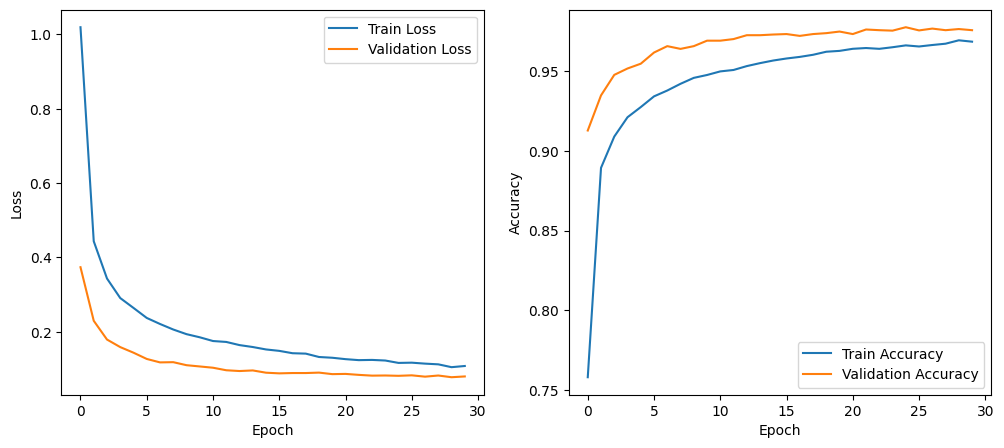

In [20]:
## 9. Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(valid_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(valid_acc_hist, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Optuna Optimization 

Optuna Hyperparameter Optimization with TPESampler and MedianPruner

In [21]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

In [22]:
def objective(trial):
    # Suggest hyperparameters
    h_size = [
        trial.suggest_int('h1_size', 32, 256),
        trial.suggest_int('h2_size', 32, 128),
        trial.suggest_int('h3_size', 16, 64)
    ]
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    
    # Create model with suggested hyperparameters
    model = MNISTClass(in_size=n_features, h_size=h_size, o_size=10).to(device)
    
    # Create new data loaders with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size)
    
    # Training setup
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    
    # Training loop with pruning
    for epoch in range(10):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Validation accuracy for pruning
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                y_pred = model(x_batch)
                val_correct += (y_pred.argmax(dim=1) == y_batch).sum().item()
        
        val_acc = val_correct / len(val_dataset)
        trial.report(val_acc, epoch)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return val_acc


In [23]:
# Create study with TPESampler and MedianPruner
sampler = TPESampler(seed=42)
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=2, interval_steps=1)

study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=50)

[I 2025-05-25 23:22:18,815] A new study created in memory with name: no-name-1c67c0ee-ac60-424b-8ece-78c75a7b1176
[I 2025-05-25 23:22:31,230] Trial 0 finished with value: 0.9782857142857143 and parameters: {'h1_size': 116, 'h2_size': 124, 'h3_size': 51, 'lr': 0.0015751320499779737, 'dropout_rate': 0.1624074561769746, 'batch_size': 128}. Best is trial 0 with value: 0.9782857142857143.
[I 2025-05-25 23:23:36,129] Trial 1 finished with value: 0.975 and parameters: {'h1_size': 167, 'h2_size': 100, 'h3_size': 17, 'lr': 0.008706020878304856, 'dropout_rate': 0.4329770563201687, 'batch_size': 32}. Best is trial 0 with value: 0.9782857142857143.
[I 2025-05-25 23:24:18,498] Trial 2 finished with value: 0.9721428571428572 and parameters: {'h1_size': 100, 'h2_size': 82, 'h3_size': 37, 'lr': 0.0003823475224675188, 'dropout_rate': 0.34474115788895177, 'batch_size': 128}. Best is trial 0 with value: 0.9782857142857143.
[I 2025-05-25 23:25:34,289] Trial 3 finished with value: 0.9777142857142858 and pa

In [24]:
# Print best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Validation Accuracy: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Validation Accuracy: 0.9804
  Params: 
    h1_size: 196
    h2_size: 99
    h3_size: 57
    lr: 0.0005896073175606767
    dropout_rate: 0.37529180478007984
    batch_size: 64


In [25]:
# 11. Train final model with best hyperparameters
best_h_size = [trial.params['h1_size'], trial.params['h2_size'], trial.params['h3_size']]
best_lr = trial.params['lr']
best_dropout = trial.params['dropout_rate']
best_batch_size = trial.params['batch_size']

In [26]:
class OptimizedMNISTClassifier(nn.Module):
    def __init__(self, in_size, h_size, o_size, dropout_rate):
        super(OptimizedMNISTClassifier, self).__init__()
        layers = []
        layers.append(nn.Linear(in_size, h_size[0]))
        layers.append(nn.BatchNorm1d(h_size[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        for i in range(len(h_size)-1):
            layers.append(nn.Linear(h_size[i], h_size[i+1]))
            layers.append(nn.BatchNorm1d(h_size[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(h_size[-1], o_size))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [27]:
# Create and train optimized model
model = OptimizedMNISTClassifier(in_size=n_features, h_size=best_h_size, o_size=10, dropout_rate=best_dropout).to(device)
train_loader = DataLoader(train_dataset, best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, best_batch_size)
test_loader = DataLoader(test_dataset, best_batch_size)

optimizer = optim.Adam(model.parameters(), lr=best_lr)
loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

In [28]:
n_epochs = 30
best_valid_loss = torch.inf

In [29]:
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x_batch.size(0)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            y_pred = model(x_batch)
            val_loss += loss_fn(y_pred, y_batch).item() * x_batch.size(0)
    
    val_loss /= len(val_dataset)
    scheduler.step(val_loss)
    
    if val_loss < best_valid_loss:
        torch.save(model.state_dict(), 'optimized_model.pt')
        best_valid_loss = val_loss
        print(f"Epoch {epoch+1}: Model saved with val loss: {val_loss:.4f}")


Epoch 1: Model saved with val loss: 0.1959
Epoch 2: Model saved with val loss: 0.1419
Epoch 3: Model saved with val loss: 0.1253
Epoch 4: Model saved with val loss: 0.1108
Epoch 5: Model saved with val loss: 0.1106
Epoch 6: Model saved with val loss: 0.0931
Epoch 7: Model saved with val loss: 0.0894
Epoch 8: Model saved with val loss: 0.0842
Epoch 9: Model saved with val loss: 0.0826
Epoch 12: Model saved with val loss: 0.0785
Epoch 17: Model saved with val loss: 0.0740
Epoch 20: Model saved with val loss: 0.0724
Epoch 21: Model saved with val loss: 0.0708
Epoch 26: Model saved with val loss: 0.0680


In [30]:
# Final evaluation
model.load_state_dict(torch.load('optimized_model.pt'))
model.eval()
test_correct = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        test_correct += (y_pred.argmax(dim=1) == y_batch).sum().item()

optimized_test_acc = test_correct / len(test_dataset)

In [31]:

print(f"\nOptimized Model Test Accuracy: {optimized_test_acc:.4f}")
print(f"Original Model Test Accuracy: {test_acc:.4f}")
print(f"Random Forest Test Accuracy: {rf_accuracy:.4f}")


Optimized Model Test Accuracy: 0.9854
Original Model Test Accuracy: 0.9803
Random Forest Test Accuracy: 0.9630


visualization

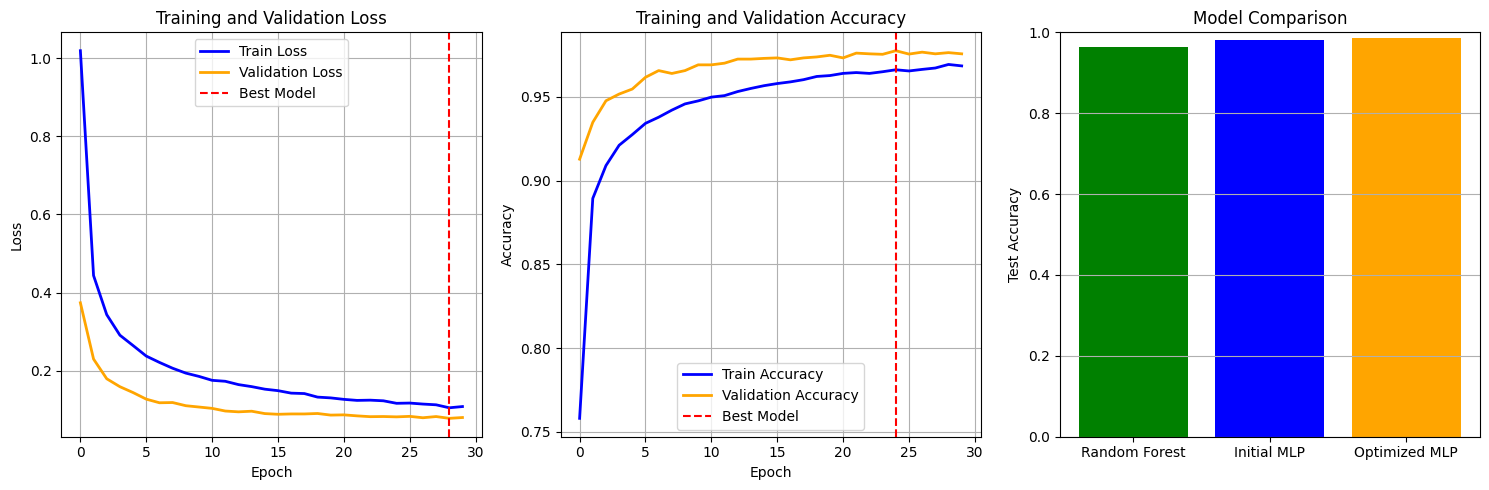

In [32]:
plt.figure(figsize=(15, 5))

#  Loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_hist, label='Train Loss', color='blue', linewidth=2)
plt.plot(valid_loss_hist, label='Validation Loss', color='orange', linewidth=2)
plt.axvline(x=np.argmin(valid_loss_hist), color='red', linestyle='--', label='Best Model')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

#  Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_acc_hist, label='Train Accuracy', color='blue', linewidth=2)
plt.plot(valid_acc_hist, label='Validation Accuracy', color='orange', linewidth=2)
plt.axvline(x=np.argmax(valid_acc_hist), color='red', linestyle='--', label='Best Model')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#model comparision
plt.subplot(1, 3, 3)
models = ['Random Forest', 'Initial MLP', 'Optimized MLP']
accuracies = [rf_accuracy, test_acc, optimized_test_acc]
plt.bar(models, accuracies, color=['green', 'blue', 'orange'])
plt.title('Model Comparison')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [33]:
import optuna.visualization as vis

In [34]:
fig1 = vis.plot_optimization_history(study)
fig1.show()

In [35]:
fig2 = vis.plot_param_importances(study)
fig2.show()

In [36]:
fig3 = vis.plot_parallel_coordinate(study)
fig3.show()